#**Import Libraries**

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt


#**Load Data and Display**

In [2]:
# Upload your file
from google.colab import files
uploaded = files.upload()


Saving courbes-de-production-mensuelles-eolien-solaire-complement-de-remuneration.csv to courbes-de-production-mensuelles-eolien-solaire-complement-de-remuneration.csv


In [3]:
# Load the dataset
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

In [4]:
# Display the first few rows of the dataset
data.head()

# Display a summary of the dataset
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date and Hour  59806 non-null  object 
 1   Date           59806 non-null  object 
 2   StartHour      59806 non-null  object 
 3   EndHour        59806 non-null  object 
 4   Source         59806 non-null  object 
 5   Production     59804 non-null  float64
 6   dayOfYear      59806 non-null  int64  
 7   dayName        59806 non-null  object 
 8   monthName      59806 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.1+ MB


,Production,dayOfYear
count,59804.000000,59806.000000
mean,2792.859775,172.454720
std,3190.239316,104.937607
min,0.000000,1.000000
25%,42.000000,84.000000
50%,1871.000000,164.000000
75%,4053.250000,262.000000
max,17220.000000,366.000000


#**Preprocess the Data**

In [5]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data['StartHour'] = data['StartHour'].replace('24:00:00', '00:00:00')
data['EndHour'] = data['EndHour'].replace('24:00:00', '00:00:00')
data['StartHour'] = pd.to_datetime(data['Date'].dt.strftime('%Y-%m-%d') + ' ' + data['StartHour'])
data['EndHour'] = pd.to_datetime(data['Date'].dt.strftime('%Y-%m-%d') + ' ' + data['EndHour'])


In [6]:
# Handle missing values in the 'Production' column
data['Production'].fillna(data['Production'].mean(), inplace=True)

In [7]:
# Select features and target
features = data[['StartHour', 'EndHour', 'Source', 'dayOfYear']]
target = data['Production']

In [8]:
# Encode the categorical 'Source' column
features = pd.get_dummies(features, columns=['Source'], drop_first=True)

In [9]:
# Convert datetime features to numerical features (e.g., timestamp)
features['StartHour'] = features['StartHour'].astype(int) / 10**9
features['EndHour'] = features['EndHour'].astype(int) / 10**9

In [10]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [11]:
# Normalise the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#**Train and Evaluate LightGBM Regressor model**

In [16]:
from lightgbm import LGBMRegressor

# Train the LightGBM Regressor model
lgb_model = LGBMRegressor(random_state=42)
lgb_model.fit(X_train_scaled, y_train)

# Predict with the LightGBM Regressor model
y_pred_lgb = lgb_model.predict(X_test_scaled)

# Evaluate the LightGBM Regressor model
lgb_mae = mean_absolute_error(y_test, y_pred_lgb)
lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
lgb_r2 = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Regressor - MAE: {lgb_mae:.2f}, RMSE: {lgb_rmse:.2f}, R²: {lgb_r2:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 761
[LightGBM] [Info] Number of data points in the train set: 41864, number of used features: 4
[LightGBM] [Info] Start training from score 2799.658343
LightGBM Regressor - MAE: 1410.35, RMSE: 1797.96, R²: 0.68


#**Train R², Test R² (Accuracy), and Overfitting Status Calculation**

In [18]:
# Calculate Train R²
y_train_pred_lgb = lgb_model.predict(X_train_scaled)
lgb_r2_train = r2_score(y_train, y_train_pred_lgb)
print(f"LightGBM Regressor - Train R²: {lgb_r2_train:.2f}")

# Calculate Test R² (Test Accuracy)
lgb_r2_test = r2_score(y_test, y_pred_lgb)
print(f"LightGBM Regressor - Test R² (Test Accuracy): {lgb_r2_test:.2f}")

# Calculate Overfitting Status
overfitting_status_lgb = (lgb_r2_train - lgb_r2_test) * 100
print(f"LightGBM Regressor - Overfitting Status: {overfitting_status_lgb:.2f}%")


LightGBM Regressor - Train R²: 0.69
LightGBM Regressor - Test R² (Test Accuracy): 0.68
LightGBM Regressor - Overfitting Status: 0.99%


#**Visualizing Production**
#**Line Plot, Scatter Plot, Residual Analysis, and Box Plot**



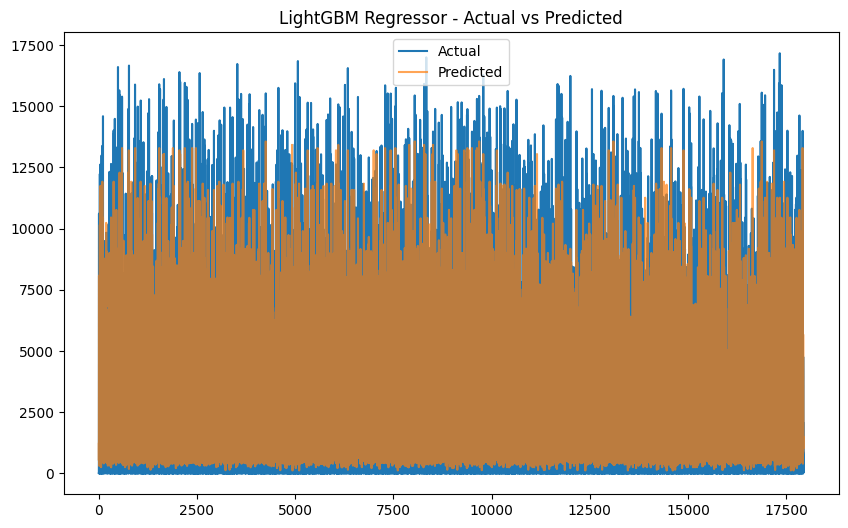

In [20]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_lgb, label='Predicted', alpha=0.7)
plt.title('LightGBM Regressor - Actual vs Predicted')
plt.legend()
plt.show()


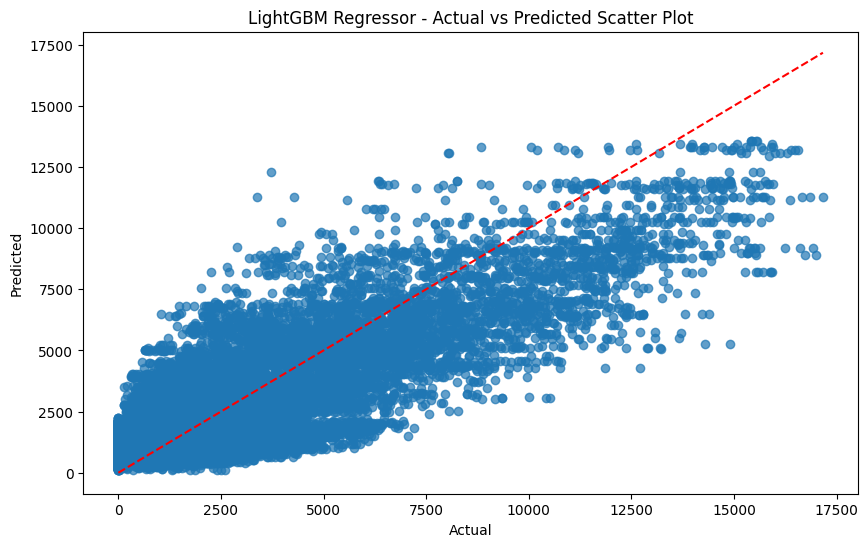

In [21]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values, y_pred_lgb, alpha=0.7)
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('LightGBM Regressor - Actual vs Predicted Scatter Plot')
plt.show()

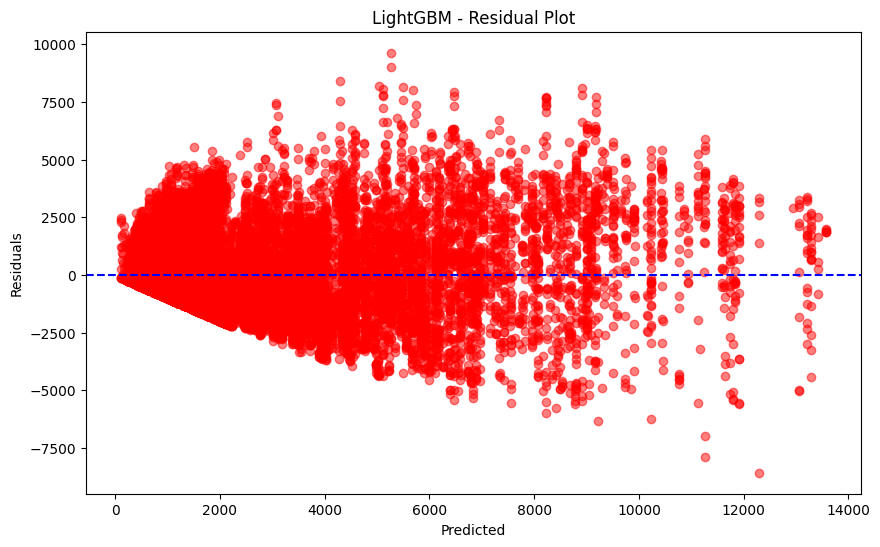

In [22]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred_lgb
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lgb, residuals, color='red', alpha=0.5)
plt.axhline(y=0, color='blue', linestyle='--')
plt.title('LightGBM - Residual Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()


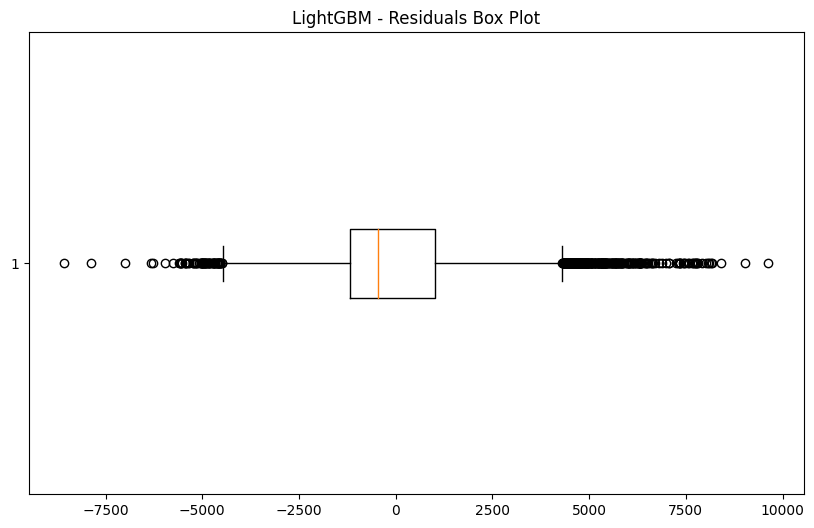

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, vert=False)
plt.title('LightGBM - Residuals Box Plot')
plt.show()
